# Ridge

In [35]:
import warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import fAux
import matplotlib.pyplot as plt
import seaborn as sns
import sys



In [36]:
np.random.seed(1) #to fix the results
rs = 2

In [37]:
df = pd.read_csv('USDCAD_H3_200001030000_202107201800.csv', sep='\t')
df['<DATETIME>'] = pd.to_datetime(df['<DATE>'] + ' ' + df['<TIME>'])
df = df.set_index('<DATETIME>')
df.drop(['<TIME>'], axis=1, inplace=True)
df.drop(['<DATE>'], axis=1, inplace=True)


In [38]:
#save the close and open for white reality check
openp = df['<OPEN>'].copy() #for the case we want to enter trades at the open


In [39]:
##build window momentum features
for n in list(range(1,21)): #takes a long time, just use 5 instead of 21
    name = 'ret' + str(n)
    df[name] = df["<OPEN>"].pct_change(periods=n).fillna(0) #for trading with open
   

In [40]:
#build date time features
df["hour"] = df.index.hour.values
df["day"] = df.index.dayofweek.values


In [41]:
#build target assuming we know today's open
df['retFut1'] = df['<OPEN>'].pct_change(1).shift(-1).fillna(0) #if you enter the trade immediately after the open


In [42]:
#Since we are trading right after the open, 
#we only know yesterday's  high low close volume spread etc.
df['<HIGH>'] = df['<HIGH>'].shift(1)
df['<LOW>'] = df['<LOW>'].shift(1)
df['<CLOSE>'] = df['<CLOSE>'].shift(1)
df['<VOL>'] = df['<VOL>'].shift(1)
df['<SPREAD>'] = df['<SPREAD>'].shift(1)

In [43]:
#select the features (by dropping)
cols_to_drop = ["<OPEN>","<HIGH>","<LOW>","<CLOSE>","<TICKVOL>","<VOL>","<SPREAD>"]  #optional
df.drop(cols_to_drop, axis=1, inplace=True)


In [44]:
#distribute the df data into X inputs and y target
X = df.drop(['retFut1'], axis=1)
y = df[['retFut1']]

#select the samples
x_train = X.iloc[0:10000]
x_test = X.iloc[10000:12000]

y_train = y.iloc[0:10000]
y_test = y.iloc[10000:12000]

In [45]:
#set up the grid search and fit

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from scipy.stats import spearmanr
from sklearn.metrics import make_scorer 
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import mutual_info_regression 
from sklearn.feature_selection import f_regression 
import detrendPrice 
import WhiteRealityCheckFor1 


In [46]:
def information_coefficient(y_true, y_pred):
    rho, pval = spearmanr(y_true,y_pred) #spearman's rank correlation
    print (rho)
    return rho

def sharpe(y_true, y_pred):
    positions = np.where(y_pred> 0,1,-1 )
    dailyRet = pd.Series(positions).shift(0).fillna(0).values * y_true
    dailyRet = np.nan_to_num(dailyRet)
    ratio = (252.0 ** (1.0/2.0)) * np.mean(dailyRet) / np.std(dailyRet)
    return ratio

### INSTRUCTIONS:
We will now use  selector SelectPercentile with a custom selector scoring function.  
SelectPercentile has a parameter called score_func which accepts a custom selector scoring function,  
as long as it has specific format.  
The format has to be like that of f_regression (the model scoring function):  
https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.f_regression.html#sklearn.feature_selection.f_regression
https://archive.is/qxCbT  
Following this model, fill in the missing code in information_coefficient_select (=Spearman correlation).  
See Spearman correlation coefficient, slide 39 RegressionChannelSimple.pptx (Pandas Homework).

In [54]:
def information_coefficient_select(X, y, method = 'spearman'):
        '''
        Function taking two arrays X and y, and returning a pair of arrays (scores, pvalues) 
        or a single array with scores.
        '''    
        # Model: https://archive.is/qxCbT i.e., sklearn.feature_selection.f_regression
        # use spearmanr here 

        rho_arr = np.zeros(X.shape[1])  # (array of zeros)
        pval_arr = np.zeros(X.shape[1])  # (array of zeros)

        # make sure it works for both pandas DataFrame and numpy array
        X_values = X.values if hasattr(X, "values") else X
        y_values = y.values.ravel() if hasattr(y, "values") else np.ravel(y)


        if method == 'spearman':
            for i in range(X_values.shape[1]):
                rho, pval = spearmanr(X_values[:, i], y_values)
                rho_arr[i] = rho
                pval_arr[i] = pval


        # elif method == 'f_regression':
        #      rho_arr, pval_arr = f_regression(X, y.values.ravel())

        # else:
        #      raise ValueError("Method must be either 'spearman' or 'f_regression'.")
        else:
            raise ValueError("Method must be 'spearman'.")

        return rho_arr, pval_arr


In [55]:
myscorer = make_scorer(information_coefficient, greater_is_better=True)

percentile = 50
selector = SelectPercentile(score_func=information_coefficient_select, percentile=percentile) 


In [56]:
numeric_sub_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('scaler', StandardScaler()),
    ('selector', selector)])

categorical_sub_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])


In [57]:
print(x_train.dtypes)
numeric_features_ix = x_train.select_dtypes(include=['float64']).columns
categorical_features_ix = x_train.select_dtypes(include=['int64']).columns


ret1     float64
ret2     float64
ret3     float64
ret4     float64
ret5     float64
ret6     float64
ret7     float64
ret8     float64
ret9     float64
ret10    float64
ret11    float64
ret12    float64
ret13    float64
ret14    float64
ret15    float64
ret16    float64
ret17    float64
ret18    float64
ret19    float64
ret20    float64
hour       int32
day        int32
dtype: object


In [58]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_sub_pipeline, numeric_features_ix),
        ('cat', categorical_sub_pipeline, categorical_features_ix)], remainder='passthrough')

ridge = Ridge(max_iter=1000) 

pipe = Pipeline(steps=[('preprocessor', preprocessor),('ridge', ridge)])


a_rs = np.logspace(-7, 0, num=20, endpoint = True)

In [59]:
print(type(x_train))
print(x_train.shape)
print(type(y_train))
print(y_train.values.ravel().shape)

<class 'pandas.core.frame.DataFrame'>
(10000, 22)
<class 'pandas.core.frame.DataFrame'>
(10000,)


In [60]:
param_grid =  [{'ridge__alpha': a_rs}]

grid_search = RandomizedSearchCV(pipe, param_grid, cv=5, scoring=myscorer, return_train_score=True, random_state=rs)
#grid_search = GridSearchCV(pipe, param_grid, cv=5, scoring=myscorer, return_train_score=True)

# grid_search.fit(x_train.values, y_train.values.ravel())
grid_search.fit(x_train, y_train.values.ravel())

best_parameters = grid_search.best_params_
best_model = grid_search.best_estimator_


print("Best parameters : {}".format(best_parameters))
#print('Best estimator {}'.format(best_model))
print("Best cross-validation score : {:.2f}".format(grid_search.best_score_*100))
results = pd.DataFrame(grid_search.cv_results_)

#print(results.T)
results.to_csv("results_ridgereg.csv")

0.03910894966374283
0.06781457977826946
0.054750797979115404
0.06965247126874476
0.013700176794927977
0.0737874507389771
0.0692660734287696
0.056236299785286686
0.020026984880897304
0.07041680180375455
0.039107828370409055
0.06781475552648178
0.05475172949848525
0.06965255984036217
0.013703565335069277
0.07378767256696331
0.0692651179185935
0.056236585469939405
0.020024246608797654
0.07041675655682837
0.039113154326237215
0.06780319675042663
0.05466247014244085
0.06967147124007461
0.013718045756607133
0.073802270146914
0.06929191720400399
0.056229859845235076
0.020034875694581344
0.07040540849649023
0.039107828370409055
0.06781475552648178
0.05475172949848525
0.06965255984036217
0.013703565335069277
0.07378763347254932
0.0692651179185935
0.056236585469939405
0.020024246608797654
0.07041675655682837
0.039107828370409055
0.0678147861010691
0.05475172949848525
0.06965291518153487
0.013703565335069277
0.07378781921789146
0.0692651179185935
0.05623634112975524
0.020024246608797654
0.0704165

In [61]:
print(results.T)

                                                          0  \
mean_fit_time                                      0.071486   
std_fit_time                                       0.029548   
mean_score_time                                    0.005306   
std_score_time                                     0.001207   
param_ridge__alpha                                 0.002637   
params              {'ridge__alpha': 0.0026366508987303553}   
split0_test_score                                  0.039109   
split1_test_score                                  0.054751   
split2_test_score                                    0.0137   
split3_test_score                                  0.069266   
split4_test_score                                  0.020027   
mean_test_score                                    0.039371   
std_test_score                                     0.020801   
rank_test_score                                           2   
split0_train_score                                 0.06

### train set

In [62]:
positions = np.where(grid_search.predict(x_train)> 0,1,-1 ) #POSITIONS


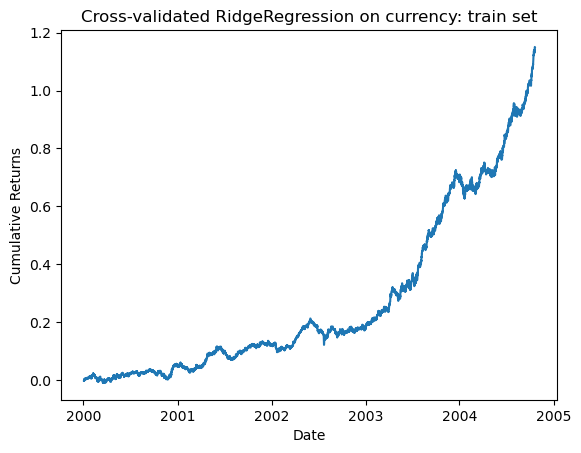

In [63]:
dailyRet = pd.Series(positions).fillna(0).values * y_train.retFut1 #for trading right after the open

dailyRet = dailyRet.fillna(0)

cumret = np.cumprod(dailyRet + 1) - 1

plt.figure(1)
plt.plot(cumret.index, cumret)
plt.title('Cross-validated RidgeRegression on currency: train set')
plt.ylabel('Cumulative Returns')
plt.xlabel('Date')
#plt.show()
plt.savefig(r'Results\%s.png' %("TrainCumulative"))


In [64]:
cagr = (1 + cumret[-1]) ** (252 / len(cumret)) - 1
maxDD, maxDDD = fAux.calculateMaxDD(cumret)
ratio = (252.0 ** (1.0/2.0)) * np.mean(dailyRet) / np.std(dailyRet)
print (('In-sample: CAGR={:0.6} Sharpe ratio={:0.6} maxDD={:0.6} maxDDD={:d} Calmar ratio={:0.6}\n'\
).format(cagr, ratio, maxDD, maxDDD.astype(int), -cagr/maxDD))

In-sample: CAGR=0.01948 Sharpe ratio=0.769354 maxDD=-0.0752582 maxDDD=1362 Calmar ratio=0.258842



### test set

Out-of-sample: CAGR=0.0112356 Sharpe ratio=0.360234 maxDD=-0.0706479 maxDDD=1555 Calmar ratio=0.159037  Rho=0.0378357 PVal=0.0907199



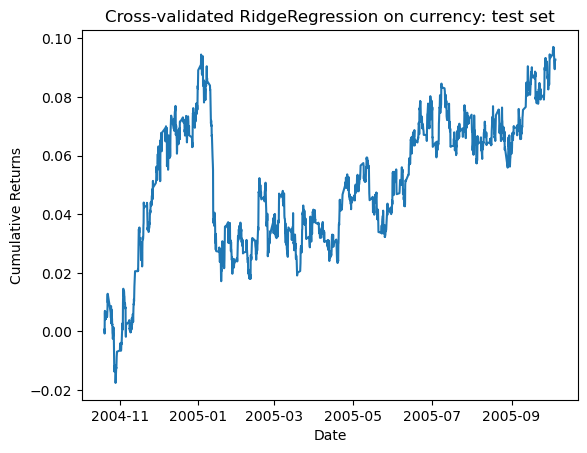

In [65]:
positions2 = np.where(grid_search.predict(x_test)> 0,1,-1 ) #POSITIONS


dailyRet2 = pd.Series(positions2).fillna(0).values * y_test.retFut1 #for trading right after the open
dailyRet2 = dailyRet2.fillna(0)

cumret2 = np.cumprod(dailyRet2 + 1) - 1

plt.figure(2)
plt.plot(cumret2.index, cumret2)
plt.title('Cross-validated RidgeRegression on currency: test set')
plt.ylabel('Cumulative Returns')
plt.xlabel('Date')
#plt.show()
plt.savefig(r'Results\%s.png' %("TestCumulative"))

rho, pval = spearmanr(y_test,grid_search.predict(x_test)) #spearman's rank correlation: very small but significant

cagr = (1 + cumret2[-1]) ** (252 / len(cumret2)) - 1
maxDD, maxDDD = fAux.calculateMaxDD(cumret2)
ratio = (252.0 ** (1.0/2.0)) * np.mean(dailyRet2) / np.std(dailyRet2)
print (('Out-of-sample: CAGR={:0.6} Sharpe ratio={:0.6} maxDD={:0.6} maxDDD={:d} Calmar ratio={:0.6}  Rho={:0.6} PVal={:0.6}\n'\
).format(cagr, ratio, maxDD, maxDDD.astype(int), -cagr/maxDD, rho, pval))

In [66]:
#plot the residuals
true_y = y_test.values.ravel()
pred_y = grid_search.predict(x_test)
residuals = np.subtract(true_y, pred_y)

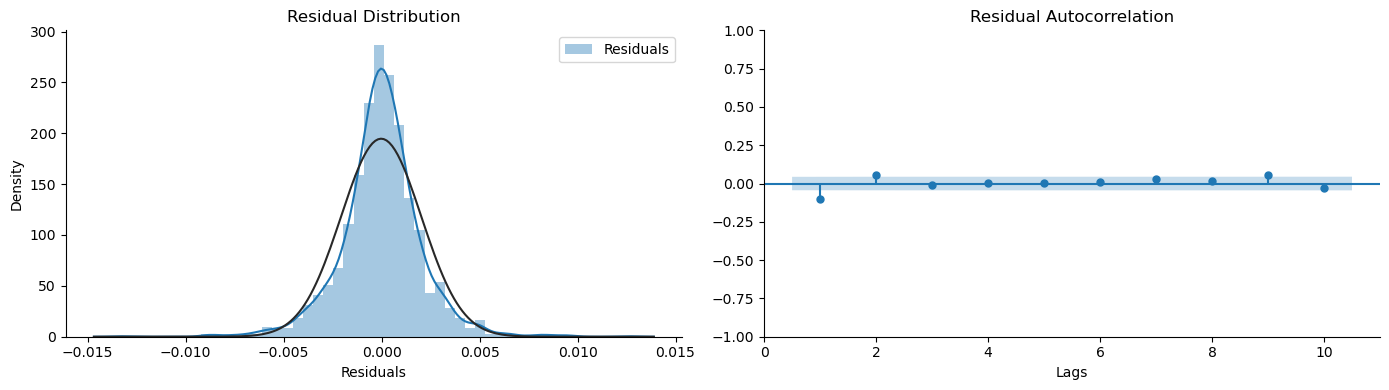

In [68]:
from scipy.stats import norm
from statsmodels.graphics.tsaplots import plot_acf
fig, axes = plt.subplots(ncols=2, figsize=(14,4))
sns.distplot(residuals, fit=norm, ax=axes[0], axlabel='Residuals', label='Residuals')
axes[0].set_title('Residual Distribution')
axes[0].legend()
plot_acf(residuals, lags=10, zero=False, ax=axes[1], title='Residual Autocorrelation')
axes[1].set_xlabel('Lags')
sns.despine()
fig.tight_layout();
#plt.show()
plt.savefig(r'Results\%s.png' %("Residuals"))



In [ ]:
#Residual autocorrelation
#If the p-value of the test is greater than the required significance (>0.05), residuals are independent
import statsmodels.api as sm
lb = sm.stats.acorr_ljungbox(residuals, lags=[10], boxpierce=False)
# print("Ljung-Box test p-value", lb[1])
print("Ljung-Box test p-value", lb.iloc[0, 1])  # p-value for the first lag

Ljung-Box test p-value 4.217588325011651e-05


In [75]:
lb

,lb_stat,lb_pvalue
10,37.736491,0.000042


### INSTRUCTIONS:
Use the detrendPrice.detrendPrice() to detrend the open price (openp).   
But limit the openp to the test set.   
Save the result in detrended_open.  
Calculate the forward detrended_open percent returns of period 1.   
Use fillna(0).   
Save the result in detrended_retFut1   

average return -0.000083
[-0.00014347  0.00013778]
Do not reject Ho = The population distribution of rule returns has an expected value of zero or less (because p_value is not small enough)
p_value:
0.8735999999999999


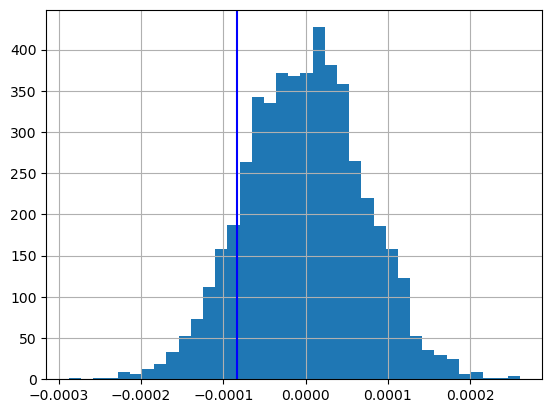

In [ ]:
# if entering the trade immediately after open

detrended_open = detrendPrice.detrendPrice(openp[10000:12000]) # only test set
detrended_retFut1 = detrended_open.pct_change(1).shift(-1).fillna(0) 
detrended_syst_rets = detrended_retFut1 * pd.Series(positions2).fillna(0)
WhiteRealityCheckFor1.bootstrap(detrended_syst_rets)
plt.show()


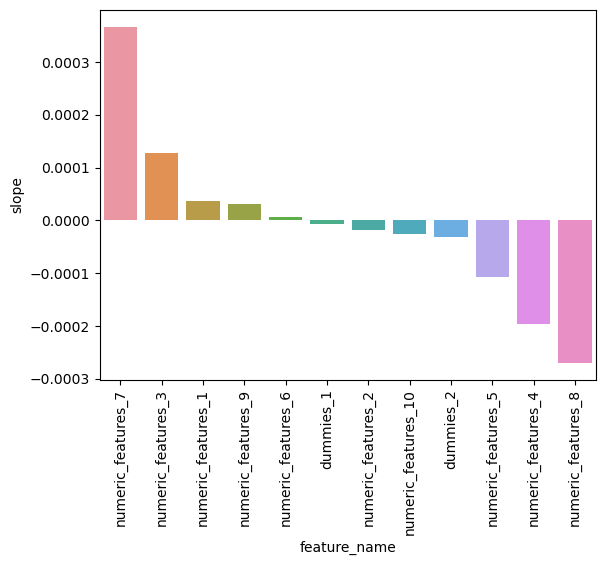

<Figure size 640x480 with 0 Axes>

In [80]:
column_names = []
num_numeric = int(len(numeric_features_ix)*percentile/100)
for i in range(1,num_numeric+1):
    column_names.append('numeric_features_'+str(i))
num_dummies = len(best_model[1].coef_.ravel().tolist())-num_numeric
for i in range(1,num_dummies+1):
    column_names.append('dummies_'+str(i))

##plot the coefficients
importance = pd.DataFrame(zip(best_model[1].coef_.ravel().tolist(), column_names))
importance.columns = ['slope','feature_name']
importance_plot = sns.barplot(x=importance['feature_name'], y=importance['slope'], data=importance,orient='v',dodge=False,order=importance.sort_values('slope',ascending=False).feature_name)
for item in importance_plot.get_xticklabels(): #rotate the x labels by 90 degrees to avoid text overlapping
    item.set_rotation(90)
plt.show()
plt.savefig(r'Results\%s.png' %("Coefficients"))

# logistic

In [1]:
import warnings
warnings.simplefilter('ignore')

import functions as ff
import numpy as np
import pandas as pd
import fAux
import matplotlib.pyplot as plt
import seaborn as sns
import sys

np.random.seed(1) #to fix the results
rs = 2
 
#file_path = 'outputfile.txt'
#sys.stdout = open(file_path, "w")

#we define this ourselves to correct the division by zero error
def single_autocorr(series, lag):
    s1 = series[lag:]
    s2 = series[:-lag]
    ms1 = np.mean(s1)
    ms2 = np.mean(s2)
    ds1 = s1 - ms1
    ds2 = s2 - ms2
    divider = np.sqrt(np.sum(ds1 * ds1)) * np.sqrt(np.sum(ds2 * ds2))
    return np.sum(ds1 * ds2) / divider if divider != 0 else 0

#df = pd.read_csv('EURUSD_H3_200001030000_202107201800.csv', sep='\t')
#df = pd.read_csv('GBPUSD_H3_200001030000_202107201800.csv', sep='\t')
#df = pd.read_csv('NZDUSD_H3_200001030000_202107201800.csv', sep='\t')
df = pd.read_csv('USDCAD_H3_200001030000_202107201800.csv', sep='\t')
#df = pd.read_csv('USDCHF_H3_200001030000_202107201800.csv', sep='\t')

df['<DATETIME>'] = pd.to_datetime(df['<DATE>'] + ' ' + df['<TIME>'])
df = df.set_index('<DATETIME>')
df.drop(['<TIME>'], axis=1, inplace=True)
df.drop(['<DATE>'], axis=1, inplace=True)

#save the open for white reality check
openp = df['<OPEN>'].copy() #for the case we want to enter trades at the open

#buld window features:
for n in list(range(1,5)): #use 5 instead of 21 because it takes a long time
    name = 'ret' + str(n)
    df[name] = df["<OPEN>"].pct_change(periods=n) #for trading with open

#new window features
df['autocorr1']=df['ret1'].rolling(50).apply(lambda s:single_autocorr(s, lag=1)).fillna(0)
lg=3
df['vratio']=df['<OPEN>'].rolling(100*lg).apply(lambda s: ff.vratio(np.log(s.values), lag=lg, cor='hom')[0]).fillna(0)

#build date-time features
df["hour"] = df.index.hour.values
df["day"] = df.index.dayofweek.values

#build target assuming we know today's open
df['retFut1'] = df['<OPEN>'].pct_change(1).shift(-1).fillna(0) #if you enter the trade immediately after the open
#df = np.log(df+1)

#transform the target
df['retFut1_categ'] = np.where((df['retFut1'] > 0), 1, 0)

#Since we are trading right after the open, 
#we only know yesterday's  high low close volume spread etc.
df['<HIGH>'] = df['<HIGH>'].shift(1)
df['<LOW>'] = df['<LOW>'].shift(1)#new window features
df['autocorr1']=df['ret1'].rolling(50).apply(lambda s:single_autocorr(s, lag=1)).fillna(0)
lg=3
df['vratio']=df['<OPEN>'].rolling(100*lg).apply(lambda s: ff.vratio(np.log(s.values), lag=lg, cor='hom')[0]).fillna(0)
df['<CLOSE>'] = df['<CLOSE>'].shift(1)
df['<VOL>'] = df['<VOL>'].shift(1)
df['<SPREAD>'] = df['<SPREAD>'].shift(1)

#select the features (by dropping)
cols_to_drop = ["<OPEN>","<HIGH>","<LOW>","<CLOSE>","<TICKVOL>","<VOL>","<SPREAD>"]  #optional
df_filtered = df.drop(cols_to_drop, axis=1)

#distribute the df data into X inputs and y target
X = df_filtered.drop(['retFut1', 'retFut1_categ'], axis=1) 
y = df_filtered[['retFut1_categ']]

#select the samples
x_train = X.iloc[0:10000]
x_test = X.iloc[10000:12000]

y_train = y.iloc[0:10000]
y_test = y.iloc[10000:12000]

df_train = df_filtered.iloc[0:10000]
df_test = df_filtered.iloc[10000:12000]

In [2]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer 
import phik
from phik.report import plot_correlation_matrix
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import mutual_info_classif 
from scipy.special import ndtr
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
import detrendPrice 
import WhiteRealityCheckFor1 


In [3]:
def phi_k(y_true, y_pred):
    dfc = pd.DataFrame({'y_true': y_true, 'y_pred': y_pred})
    try:
        phi_k_corr = dfc.phik_matrix(interval_cols=[]).iloc[1,0]
        phi_k_sig  = dfc.significance_matrix(interval_cols=[]).iloc[1,0]
        phi_k_p_val = 1 - ndtr(phi_k_sig) 
    except:
        phi_k_corr = 0
        phi_k_p_val = 0
    print(phi_k_p_val)
    return phi_k_corr

def phi_k_select_helper(y, x):
    dfc = pd.DataFrame({'y_true': y, x.name: x})
    try:
        phi_k_corr = dfc.phik_matrix(interval_cols=[x.name]).iloc[1,0]  
        phi_k_sig  = dfc.significance_matrix(interval_cols=[x.name]).iloc[1,0] 
        phi_k_p_val = 1 - ndtr(phi_k_sig) 
    except:
        phi_k_corr = 0
        phi_k_p_val = 0
    return phi_k_corr, phi_k_p_val

#list of continuous numerical variables
interval_cols = x_train.select_dtypes(include=['float64']).columns.values.tolist()

def phi_k_select(X, y):
    #Function taking two arrays X and y, and returning a pair of arrays (scores, pvalues) or a single array with scores.
    #Model: https://archive.is/qxCbT
    X = pd.DataFrame(X, columns=interval_cols)
    rho_arr = np.zeros(X.shape[1])
    pval_arr = np.zeros(X.shape[1])
    for i in range(X.shape[1]):
         rho_arr[i], pval_arr[i] = phi_k_select_helper(y,X.iloc[:, i])
    return rho_arr, pval_arr


#myscorer = None #use default accuracy score
myscorer = make_scorer(phi_k, greater_is_better=True)

percentile=50
selector = SelectPercentile(score_func= phi_k_select, percentile=percentile) 
#selector = SelectPercentile(score_func= f_classif, percentile=percentile) 
#selector = SelectPercentile(score_func= mutual_info_classif, percentile=percentile)

numeric_sub_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('scaler', StandardScaler()),
    ('selector', selector)])
categorical_sub_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])
    
print(x_train.dtypes)
numeric_features_ix = x_train.select_dtypes(include=['float64']).columns
categorical_features_ix = x_train.select_dtypes(include=['int64']).columns

ret1         float64
ret2         float64
ret3         float64
ret4         float64
autocorr1    float64
vratio       float64
hour           int32
day            int32
dtype: object


### INSTRUCTIONS:  
As regards the numeric_transformers: add the two transformer 3-element tuples  
one for numeric features and one for categorical features  
For guidance see: https://archive.is/hpwzH  

In [4]:
#Note: transformer 3-element tuples can be: ('name', function or pipeline, column_number_list or column_index)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_sub_pipeline, numeric_features_ix),
        ('cat', categorical_sub_pipeline, categorical_features_ix),
    ], remainder='passthrough')


In [5]:
logistic = LogisticRegression(max_iter=1000, solver='liblinear') 

pipe = Pipeline(steps=[('preprocessor', preprocessor),('logistic', logistic)])

c_rs = np.logspace(3, -4, num=20, endpoint = True)
#penalty type=L2 like ridge regression (small coefficients preferred), L1 like lasso  (coefficients can become zero)
p_rs= ["l1", "l2"]

param_grid =  [{'logistic__C': c_rs, 'logistic__penalty': p_rs}]

grid_search = RandomizedSearchCV(pipe, param_grid, cv=5, scoring=myscorer, return_train_score=True, random_state=rs)
#grid_search = GridSearchCV(pipe, param_grid, cv=5, scoring=myscorer, return_train_score=True)

grid_search.fit(x_train, y_train.values.ravel())

best_parameters = grid_search.best_params_
best_model = grid_search.best_estimator_


print("Best parameters : {}".format(best_parameters))
#print('Best estimator {}'.format(best_model))
print("Best cross-validation score : {:.2f}".format(grid_search.best_score_*100))
results = pd.DataFrame(grid_search.cv_results_)

#print(results.T)
results.to_csv("results_logisticreg.csv")

0.0937509048741123
1.992369865222443e-05
0.48551433475367745
0.00010214230678884384
0.3873586288430625
1.3217705059798135e-05
0.4482930806994627
1.7087910653135197e-05
0.026702688409030118
5.947777632187012e-06
0.0680827967982165
2.0858401070689148e-05
0.5347734689326877
0.0006782963704663469
0.7198804413072197
2.1229900541430702e-05
0.5211843816964098
6.627170219930534e-06
0.04623585966993882
4.332313701005397e-06
0.05839519848811414
1.2109423450423762e-05
0.47907323214048114
0.0008167081915078089
0.6721425884283068
2.2193925894420374e-05
0.5207866241944955
6.9681461928317034e-06
0.04238085904536337
1.2354224578903228e-06
0.0648843679007679
2.0474797634451036e-05
0.5215316076278231
0.0007455777135603192
0.8043023452925393
2.1726062138016644e-05
0.5099539532995016
6.7727135543149686e-06
0.05029140004708377
4.210277753102787e-06
0.07024023320273454
2.2206695184157077e-05
0.526792290121463
0.0007179761027318321
0.7113728141582618
1.9951682492136413e-05
0.5857340334044486
7.54941914027362

In [6]:
print(results.T)

                                                                         0  \
mean_fit_time                                                     4.370495   
std_fit_time                                                      3.374863   
mean_score_time                                                   0.440421   
std_score_time                                                    0.073538   
param_logistic__penalty                                                 l2   
param_logistic__C                                                 0.016238   
params                   {'logistic__penalty': 'l2', 'logistic__C': 0.0...   
split0_test_score                                                 0.045947   
split1_test_score                                                      0.0   
split2_test_score                                                      0.0   
split3_test_score                                                      0.0   
split4_test_score                                               

In-sample: CAGR=0.00592863 Sharpe ratio=0.244332 maxDD=-0.0814892 maxDDD=4994 Calmar ratio=0.0727535



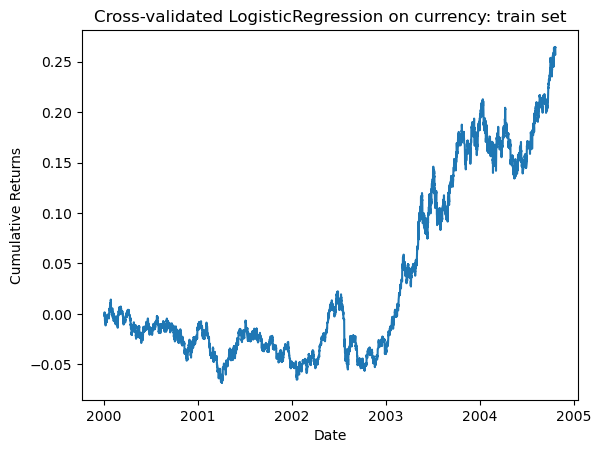

In [10]:
# Train set
# Make "predictions" on training set (in-sample)
#positions = np.where(best_model.predict(x_train)> 0,1,-1 )
positions = np.where(grid_search.predict(x_train)> 0,1,-1 ) #POSITIONS

dailyRet = pd.Series(positions).fillna(0).values * df_train.retFut1 #for trading right after the open

dailyRet = dailyRet.fillna(0)

cumret = np.cumprod(dailyRet + 1) - 1


plt.figure(1)
plt.plot(cumret.index, cumret)
plt.title('Cross-validated LogisticRegression on currency: train set')
plt.ylabel('Cumulative Returns')
plt.xlabel('Date')
#plt.show()
plt.savefig(r'Results\%s.png' %("TrainCumulative"))


cagr = (1 + cumret[-1]) ** (252 / len(cumret)) - 1
maxDD, maxDDD = fAux.calculateMaxDD(cumret)
ratio = (252.0 ** (1.0/2.0)) * np.mean(dailyRet) / np.std(dailyRet)
print (('In-sample: CAGR={:0.6} Sharpe ratio={:0.6} maxDD={:0.6} maxDDD={:d} Calmar ratio={:0.6}\n'\
).format(cagr, ratio, maxDD, maxDDD.astype(int), -cagr/maxDD))


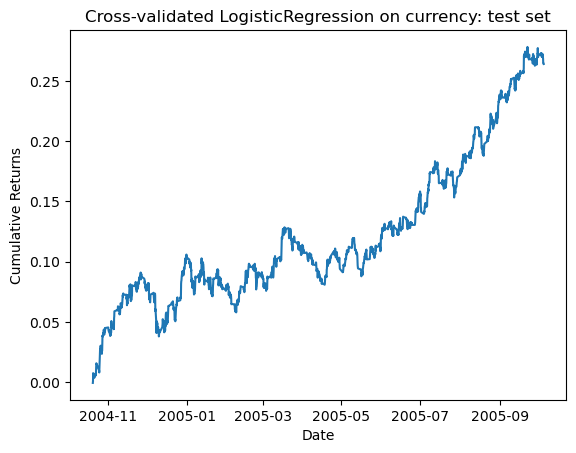

In [11]:
# Test set
# Make "predictions" on test set (out-of-sample)

#positions2 = np.where(best_model.predict(x_test)> 0,1,-1 )
positions2 = np.where(grid_search.predict(x_test)> 0,1,-1 ) #POSITIONS

dailyRet2 = pd.Series(positions2).fillna(0).values * df_test.retFut1 #for trading right after the open
dailyRet2 = dailyRet2.fillna(0)

cumret2 = np.cumprod(dailyRet2 + 1) - 1

plt.figure(2)
plt.plot(cumret2.index, cumret2)
title = 'Cross-validated LogisticRegression on currency: test set'
plt.title(title)
plt.ylabel('Cumulative Returns')
plt.xlabel('Date')
#plt.show()
plt.savefig(r'Results\%s.png' %("TestCumulative"))

Out-of-sample: CAGR=0.0299746 Sharpe ratio=0.926846 maxDD=-0.0486213 maxDDD=440 Calmar ratio=0.616491  phi_k_corr=0.126454 phi_k_p_val=0.000153906  accuracy_score=0.5385



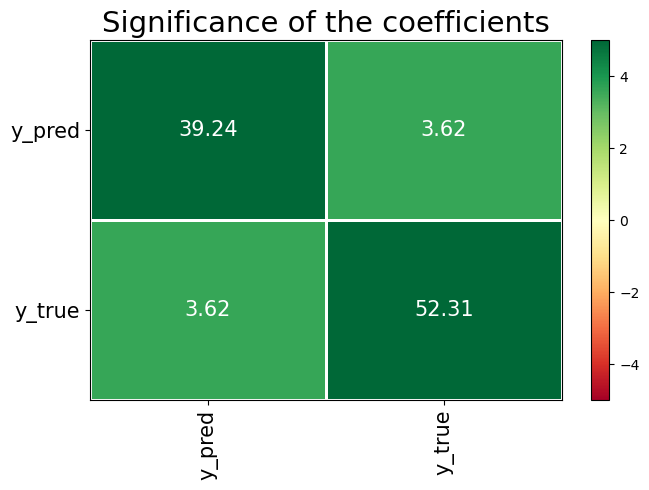

In [12]:
#metrics
accuracy_score = accuracy_score(y_test.values.ravel(), grid_search.predict(x_test))

#If this figure does not plot correctly select the lines and press F9 again
arr1 = y_test.values.ravel()
arr2 = grid_search.predict(x_test)
dfc = pd.DataFrame({'y_true': arr1, 'y_pred': arr2})
phi_k_corr = dfc.phik_matrix(interval_cols=[]).iloc[1,0]
significance_overview = dfc.significance_matrix(interval_cols=[])
phi_k_sig  = dfc.significance_matrix(interval_cols=[]).iloc[1,0]
phi_k_p_val = 1 - ndtr(phi_k_sig) 
plot_correlation_matrix(significance_overview.fillna(0).values, 
                        x_labels=significance_overview.columns, 
                        y_labels=significance_overview.index, 
                        vmin=-5, vmax=5, title="Significance of the coefficients", 
                        usetex=False, fontsize_factor=1.5, figsize=(7, 5))
plt.tight_layout()
#plt.show()
plt.savefig(r'Results\%s.png' %("PhikSignificance"))

cagr = (1 + cumret2[-1]) ** (252 / len(cumret2)) - 1
maxDD, maxDDD = fAux.calculateMaxDD(cumret2)
ratio = (252.0 ** (1.0/2.0)) * np.mean(dailyRet2) / np.std(dailyRet2)
print (('Out-of-sample: CAGR={:0.6} Sharpe ratio={:0.6} maxDD={:0.6} maxDDD={:d} Calmar ratio={:0.6}  phi_k_corr={:0.6} phi_k_p_val={:0.6}  accuracy_score={:0.6}\n'\
).format(cagr, ratio, maxDD, maxDDD.astype(int), -cagr/maxDD, phi_k_corr, phi_k_p_val, accuracy_score))


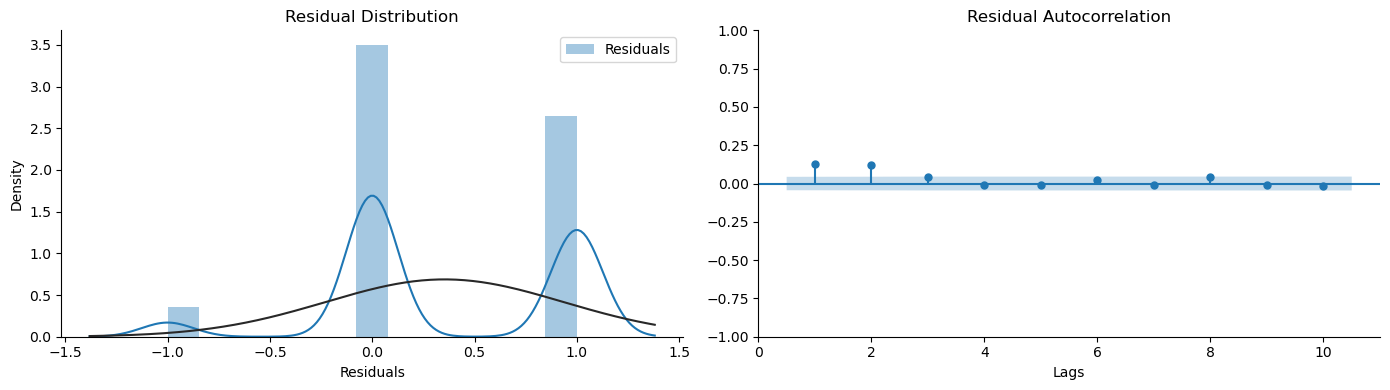

In [14]:
#plot the residuals
true_y = y_test.values.ravel()
pred_y = grid_search.predict(x_test)
residuals = np.subtract(true_y, pred_y)

from scipy.stats import norm
from statsmodels.graphics.tsaplots import plot_acf
fig, axes = plt.subplots(ncols=2, figsize=(14,4))
sns.distplot(residuals, fit=norm, ax=axes[0], axlabel='Residuals', label='Residuals')
axes[0].set_title('Residual Distribution')
axes[0].legend()
plot_acf(residuals, lags=10, zero=False, ax=axes[1], title='Residual Autocorrelation')
axes[1].set_xlabel('Lags')
sns.despine()
fig.tight_layout();
#plt.show()
plt.savefig(r'Results\%s.png' %("ResidualDistribution"))


In [16]:
#Residual autocorrelation
#If the p-value of the test is greater than the required significance (>0.05), residuals are independent
import statsmodels.api as sm
lb = sm.stats.acorr_ljungbox(residuals, lags=[10], boxpierce=False)
print("Ljung-Box test p-value", lb.iloc[0, 1])

Ljung-Box test p-value 9.905559391586245e-12


average return -0.000083
[-0.00014184  0.00013738]
Do not reject Ho = The population distribution of rule returns has an expected value of zero or less (because p_value is not small enough)
p_value:
0.8732


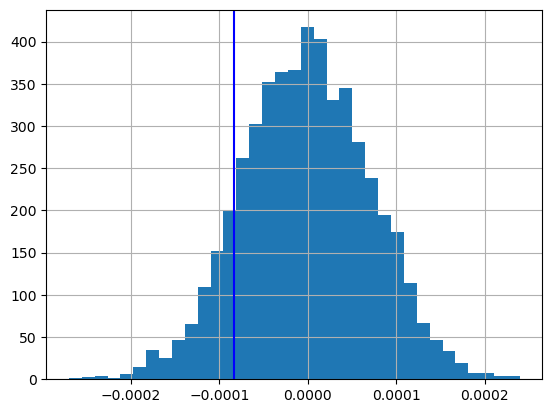

In [17]:
#Detrending Prices and Returns and white reality check
detrended_open = detrendPrice.detrendPrice(openp)
detrended_retFut1 = detrended_open.pct_change(1).shift(-1).fillna(0)
detrended_syst_rets = detrended_retFut1 * pd.Series(positions2).fillna(0)
WhiteRealityCheckFor1.bootstrap(detrended_syst_rets)
plt.show()

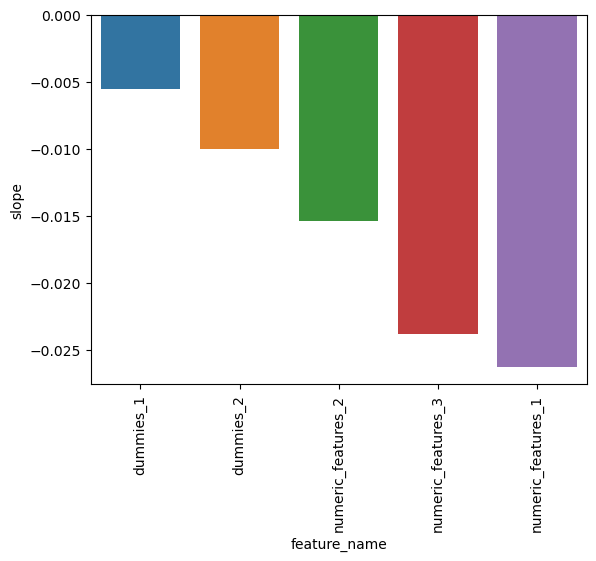

<Figure size 640x480 with 0 Axes>

In [18]:
column_names = []
num_numeric = int(len(numeric_features_ix)*percentile/100)
for i in range(1,num_numeric+1):
    column_names.append('numeric_features_'+str(i))
num_dummies = len(best_model[1].coef_.ravel().tolist())-num_numeric
for i in range(1,num_dummies+1):
    column_names.append('dummies_'+str(i))

##plot the coefficients
importance = pd.DataFrame(zip(best_model[1].coef_.ravel().tolist(), column_names))
importance.columns = ['slope','feature_name']
importance_plot = sns.barplot(x=importance['feature_name'], y=importance['slope'], data=importance,orient='v',dodge=False,order=importance.sort_values('slope',ascending=False).feature_name)
for item in importance_plot.get_xticklabels(): #rotate the x labels by 90 degrees to avoid text overlapping
    item.set_rotation(90)
plt.show()
plt.savefig(r'Results\%s.png' %("Coefficients"))